In [1]:
import sys
sys.path.append('../')

In [2]:
import tensorflow as tf

(train_images, train_labels), (test_images,
                               test_labels) = tf.keras.datasets.cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images.astype(
    'float32') / 255.0, test_images.astype('float32') / 255.0

2023-10-15 15:04:34.945966: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-15 15:04:34.946022: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-15 15:04:34.946058: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-15 15:04:34.956289: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pickle

model = tf.keras.models.Sequential()

# Input layer
model.add(tf.keras.layers.Conv2D(128, kernel_size=(
    4, 4), padding='same', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(64, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), padding='same'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Conv2D(16, kernel_size=(2, 2), padding='same'))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Dropout(0.25))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dense(64))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dense(32))
model.add(tf.keras.layers.LeakyReLU())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(len(class_names), activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# epochs = 100
# batch_size = 256
# history = model.fit(train_images, train_labels, epochs=epochs, callbacks=tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss', patience=5, verbose=2), validation_data=(test_images, test_labels))


with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

model.load_weights('weights.keras')
loss, accuracy = model.evaluate(test_images, test_labels)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

2023-10-15 15:04:37.237393: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 15:04:37.244805: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 15:04:37.244850: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 15:04:37.246560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-15 15:04:37.246593: I tensorflow/compile

313/313 [==============================] - 4s 5ms/step - loss: 0.7165 - accuracy: 0.7550
Test Loss: 0.7165145874023438
Test Accuracy: 0.7549999952316284


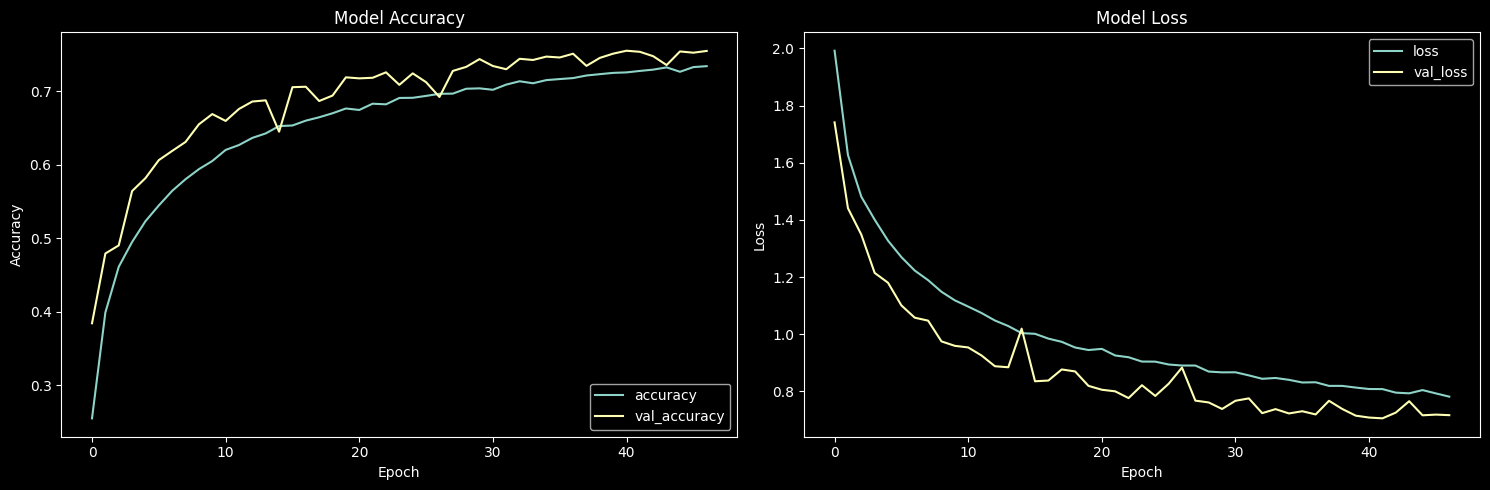

313/313 - 1s - 897ms/epoch - 3ms/step


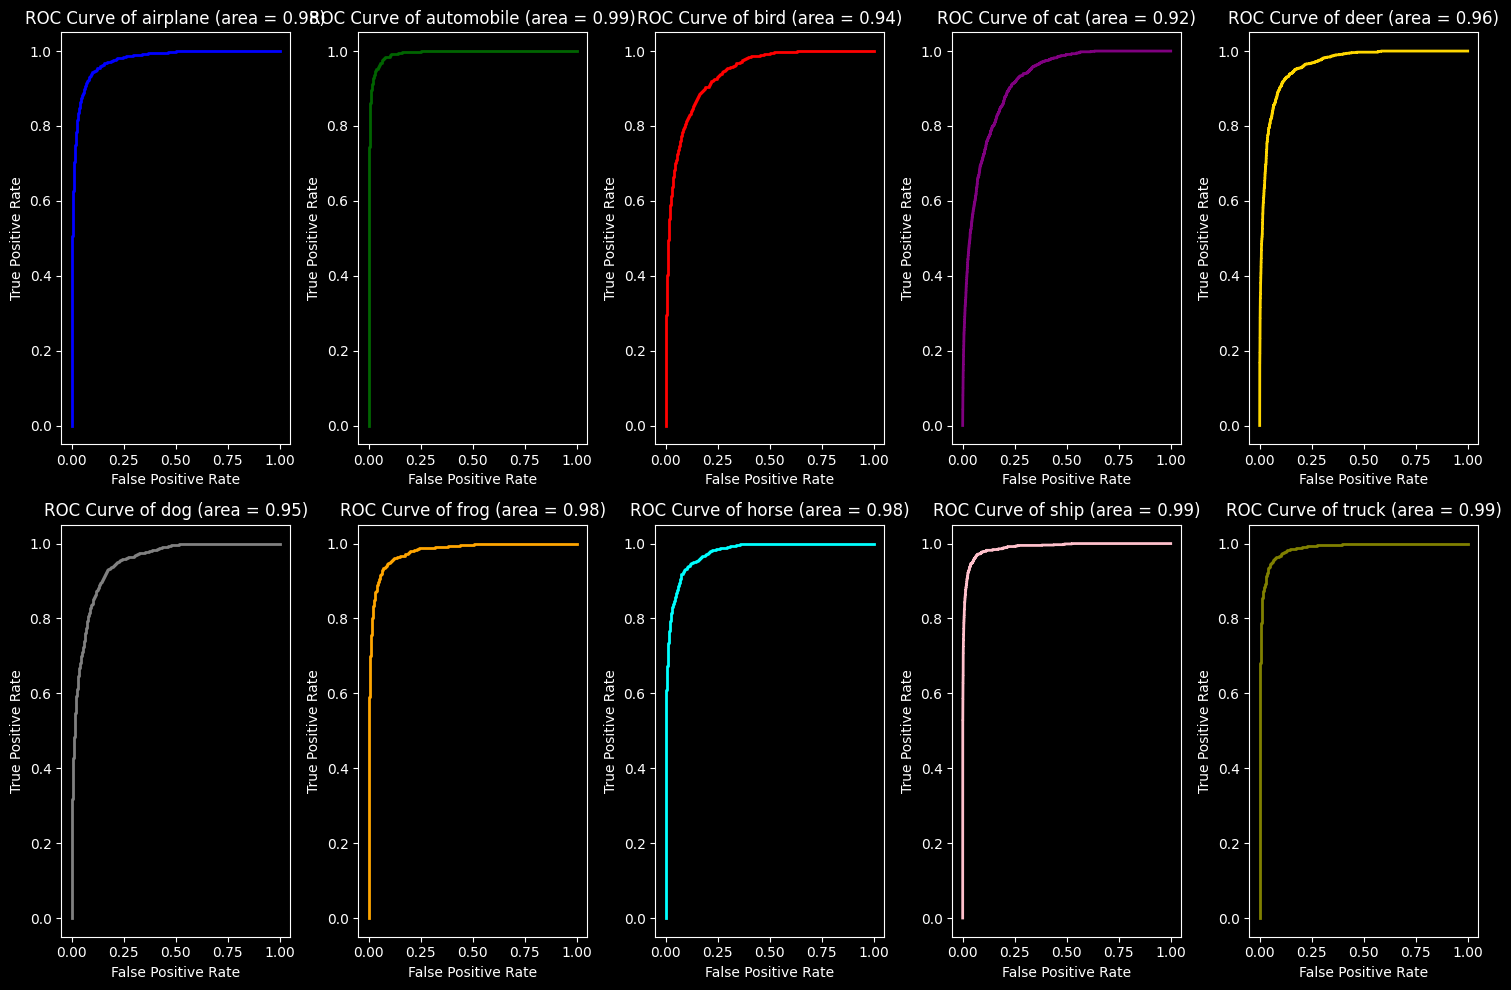

0.7277777777777779
              precision    recall  f1-score   support

    airplane       0.73      0.82      0.77      1000
  automobile       0.87      0.89      0.88      1000
        bird       0.62      0.66      0.64      1000
         cat       0.61      0.50      0.55      1000
        deer       0.71      0.70      0.70      1000
         dog       0.70      0.62      0.66      1000
        frog       0.85      0.79      0.82      1000
       horse       0.78      0.80      0.79      1000
        ship       0.83      0.90      0.86      1000
       truck       0.81      0.89      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.75      0.76      0.75     10000
weighted avg       0.75      0.76      0.75     10000



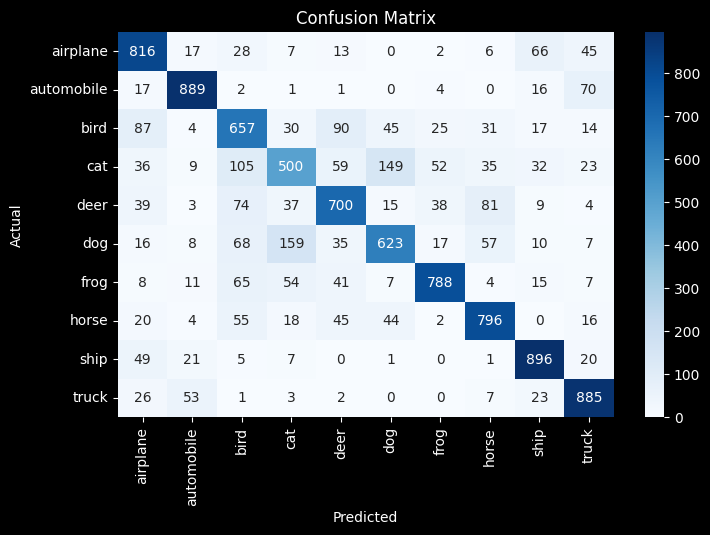

In [4]:
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score
import numpy as np
from plotting import roc_plot, plot_history, cm_plot

plot_history(history)

y_prob = model.predict(test_images, verbose=2)
y_pred = np.argmax(y_prob, axis=1)

roc_plot(test_labels, y_prob, class_names)
print(cohen_kappa_score(test_labels.squeeze(), y_pred))
print(classification_report(test_labels, y_pred, target_names=class_names))
cm_plot(confusion_matrix(test_labels, y_pred), class_names)